In [1]:
import os
import warnings
from functools import partialmethod

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xqml
from tqdm import tqdm

from tools.chi2_functions import get_lollipop_chi2
from tools.common_functions import compute_offsets, compute_theoretical_spectrum

In [2]:
tqdm.__init__ = partialmethod(tqdm.__init__, colour="green", ncols=120)
warnings.filterwarnings("ignore")

plt.rc("axes", labelsize=20, linewidth=1.5)
plt.rc("xtick", direction="in", labelsize=15, top=True)
plt.rc("ytick", direction="in", labelsize=15, right=True)

plt.rc("xtick.major", width=1.1, size=5)
plt.rc("ytick.major", width=1.1, size=5)

plt.rc("xtick.minor", width=1.1, size=3)
plt.rc("ytick.minor", width=1.1, size=3)

plt.rc("lines", linewidth=2)
plt.rc("legend", frameon=False, fontsize=15)
plt.rc("figure", dpi=100, autolayout=True, figsize=[10, 7])
plt.rc("savefig", dpi=150, bbox="tight")

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["red", "dodgerblue", "forestgreen", "goldenrod", "maroon", "cyan", "limegreen", "darkorange", "darkmagenta"])

In [3]:
N_sims = 1000

fsky = 40
nside = 16
npix = hp.nside2npix(nside)

fwhm = 1.33333 # beam in [deg] (this corresponds to 80 arcmin beam)
spec = ["EE", "BB"]

lmax = 30
ell = np.arange(2, lmax + 1)
ell_full = np.arange(2, 501)
ell_factor = ell * (ell + 1) / (2 * np.pi)

# Grid of r values
r005s = np.linspace(-0.01, 0.02, 1201)

In [4]:
CURRENT_PATH = os.path.abspath("")

masks_folder = CURRENT_PATH + "/masks/"
sims_folder = CURRENT_PATH + "/sims/"
spectra_folder = CURRENT_PATH + "/spectra/"


print(CURRENT_PATH)

/home/ggalloni/Projects/LB_handson_2024


In [5]:
############################### COMPUTE LENSING SPECTRUM ###############################

fiducial_spectrum = compute_theoretical_spectrum(lmax, r=0.0)
full_spectrum = compute_theoretical_spectrum(500, r=0.0)
print("Fiducial spectrum computed")
print(fiducial_spectrum.shape)

Fiducial spectrum computed
(31, 4)


In [6]:
noise_level = 10.0  # muK-arcmin

pixarea = hp.nside2pixarea(nside, degrees=True)
varperpix = (noise_level / 60.)**2 / pixarea

nl = varperpix * 4. * np.pi / (12*nside**2.)

noise_spectrum = np.ones_like(ell) * nl

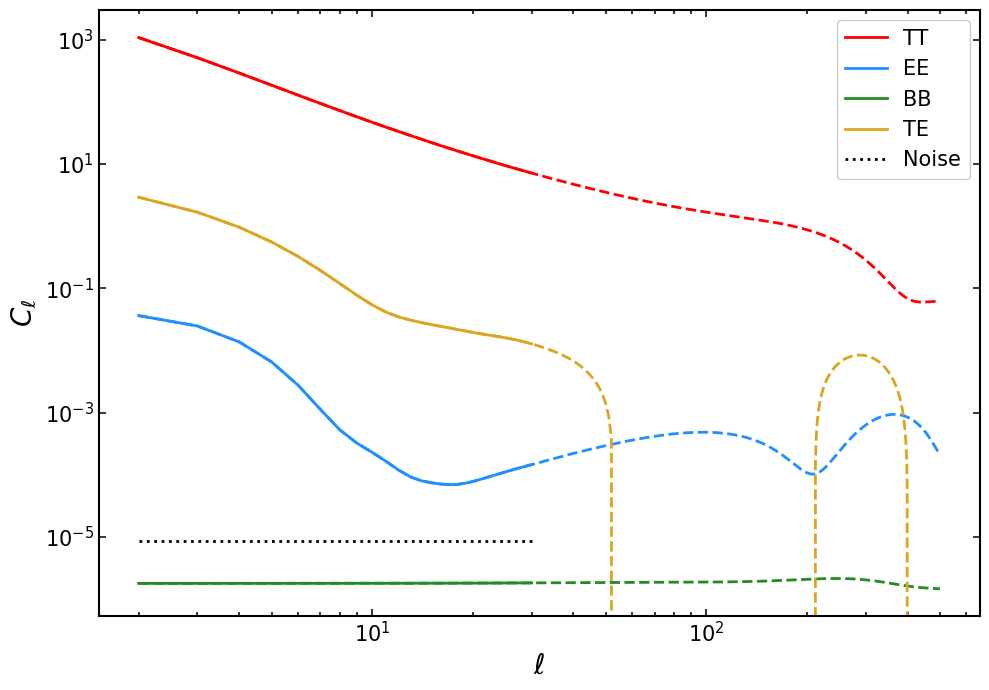

In [7]:
plt.plot(ell_full, full_spectrum[2:, 0], color = "C0", ls="--")
plt.plot(ell_full, full_spectrum[2:, 1], color = "C1", ls="--")
plt.plot(ell_full, full_spectrum[2:, 2], color = "C2", ls="--")
plt.plot(ell_full, full_spectrum[2:, 3], color = "C3", ls="--")

plt.plot(ell, fiducial_spectrum[2:, 0], label="TT", ls = "-", color = "C0")
plt.plot(ell, fiducial_spectrum[2:, 1], label="EE", ls = "-", color = "C1")
plt.plot(ell, fiducial_spectrum[2:, 2], label="BB", ls = "-", color = "C2")
plt.plot(ell, fiducial_spectrum[2:, 3], label="TE", ls = "-", color = "C3")

plt.plot(ell, noise_spectrum, label="Noise", ls = ":", color = "black")

plt.loglog()

plt.legend(loc = "upper right", frameon = True, framealpha = 1)

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()

In [8]:
#################################### LOAD TEMPLATES ####################################

file = spectra_folder + "templates_rm0p01_to_r0p02.npy"
templates = np.load(file)[:, :lmax - 1]
templates /= ell_factor[None, :]

print(templates.shape)

(1201, 29)


In [9]:
bl = hp.gauss_beam(np.deg2rad(fwhm), lmax=lmax, pol=True)
print(bl.shape)

(31, 4)


In [10]:
# sims = np.zeros((N_sims, 3, npix))
# fullsky_spectra = np.zeros((N_sims, 6, lmax - 1))

# for i in tqdm(range(N_sims), desc="Simulations".center(30)):
#     alm = hp.synalm(full_spectrum.T, new=True, lmax=lmax, verbose=False)
#     hp.almxfl(alm[0], bl[:, 0], inplace=True)
#     hp.almxfl(alm[1], bl[:, 1], inplace=True)
#     hp.almxfl(alm[2], bl[:, 2], inplace=True)

#     mapp = hp.alm2map(alm, nside, pixwin=False, verbose=False)

#     mapp[0] += np.random.normal(0, np.sqrt(varperpix/2), npix)
#     mapp[1] += np.random.normal(0, np.sqrt(varperpix), npix)
#     mapp[2] += np.random.normal(0, np.sqrt(varperpix), npix)
#     sims[i] = mapp
#     fullsky_spectra[i] = hp.anafast(mapp, lmax=lmax, pol=True)[:, 2:]
# print("Simulations done")
# print(sims.shape)
# print("Full-sky spectra computed")
# print(fullsky_spectra.shape)

         Simulations          : 100%|███████████████████████████████████████████████| 1000/1000 [03:13<00:00,  5.17it/s]

Simulations done
(1000, 3, 3072)
(1000, 6, 29)


In [28]:
filename = "sims_40fsky_1degbeam_1000sims.npy"
# np.save(sims_folder + filename, fullsky_spectra)

fullsky_spectra = np.load(sims_folder + filename)

In [29]:
filename = "fullsky_spectra_40fsky_1degbeam_1000sims.npy"
# np.save(filename, spectra_folder + fullsky_spectra)

fullsky_spectra = np.load(spectra_folder + filename)

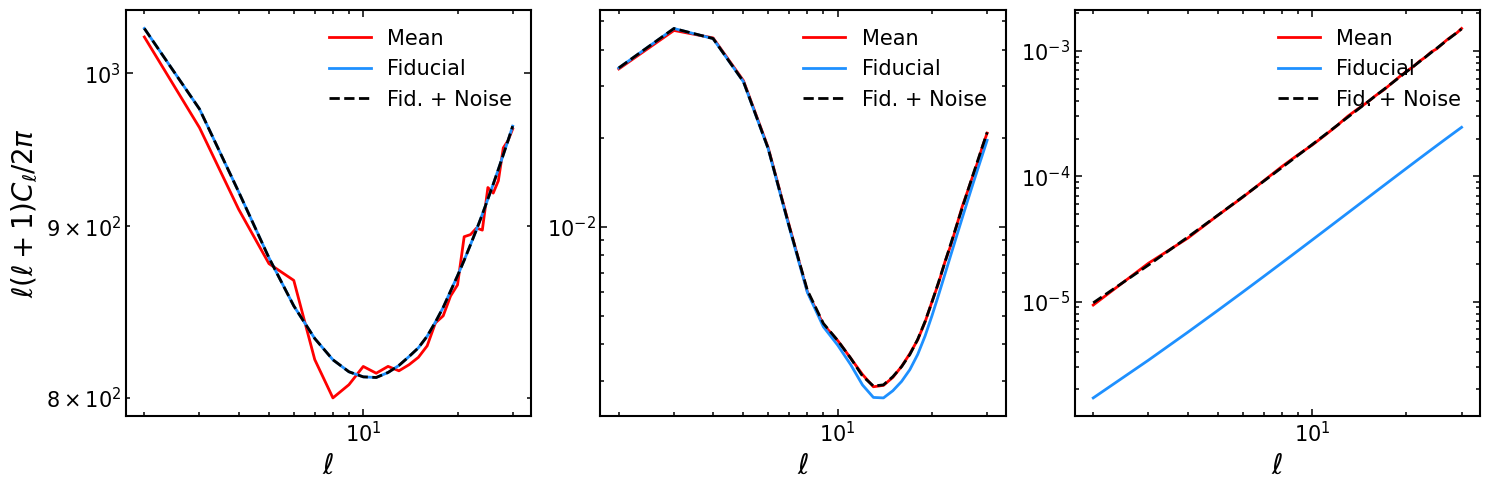

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(ell, ell_factor * np.mean(fullsky_spectra[:, 0], axis=0), label="Mean")
ax[0].plot(ell, ell_factor * fiducial_spectrum[2:, 0]*bl[2:, 0]**2, label="Fiducial")
ax[0].plot(ell, ell_factor * (fiducial_spectrum[2:, 0]*bl[2:, 0]**2 + noise_spectrum/2), label="Fid. + Noise", ls = "--", color = "black")

ax[1].plot(ell, ell_factor * np.mean(fullsky_spectra[:, 1], axis=0), label="Mean")
ax[1].plot(ell, ell_factor * fiducial_spectrum[2:, 1]*bl[2:, 1]**2, label="Fiducial")
ax[1].plot(ell, ell_factor * (fiducial_spectrum[2:, 1]*bl[2:, 1]**2 + noise_spectrum), label="Fid. + Noise", ls = "--", color = "black")

ax[2].plot(ell, ell_factor * np.mean(fullsky_spectra[:, 2], axis=0), label="Mean")
ax[2].plot(ell, ell_factor * fiducial_spectrum[2:, 2]*bl[2:, 2]**2, label="Fiducial")
ax[2].plot(ell, ell_factor * (fiducial_spectrum[2:, 2]*bl[2:, 2]**2 + noise_spectrum), label="Fid. + Noise", ls = "--", color = "black")

ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")
for i in range(3):
    ax[i].loglog()
    ax[i].legend(loc = "upper right")
    ax[i].set_xlabel(r"$\ell$")

plt.show()

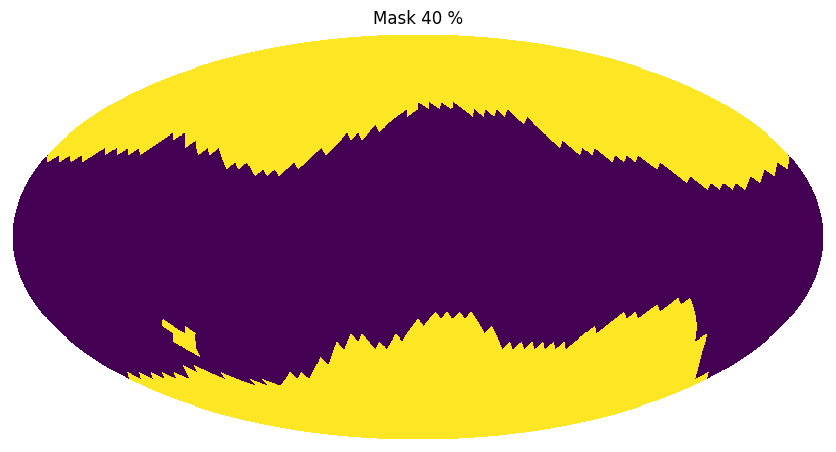

In [31]:
# mask_full = hp.read_map(masks_folder + "mask_full_ns16.fits", verbose=False, field=2)
# mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky020_ns0016.fits", verbose=False, field=2)
mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky040_ns0016.fits", verbose=False, field=2)
# mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky060_ns0016.fits", verbose=False, field=2)
# mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky070_ns0016.fits", verbose=False, field=2)
# mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky080_ns0016.fits", verbose=False, field=2)
# mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky090_ns0016.fits", verbose=False, field=2)
# mask = hp.read_map(masks_folder + "mask_T100_QU_galactic_fsky100_ns0016.fits", verbose=False, field=2)

fsky_mask = np.mean(mask)

hp.mollview(mask, title=f"Mask {fsky_mask*100:.0f} %", cbar=False)
plt.show()

In [32]:
# print some relevant info
npix = int(sum(mask))
print("fsky=%.2g %% (npix=%d)" % (100*fsky_mask,npix))
toGB = 1024. * 1024. * 1024.
emem = 8.*(npix*2*npix*2) * ( len(ell)*2 ) / toGB
print("mem=%.2g Gb" % emem)

fsky=40 % (npix=1240)
mem=2.7 Gb


In [33]:
# define parameters used later
stokes, spec, istokes, ispecs = xqml.xqml_utils.getstokes(spec=spec)
print(stokes, spec, istokes, ispecs)
nspec = len(spec)
nstoke = len(stokes)

['Q', 'U'] ['EE', 'BB'] [1, 2] [1, 2]


In [34]:
# ############## Generate White Noise ###############
varmap = np.ones(nstoke * npix) * varperpix
NoiseVar = np.diag(varmap)

In [35]:
bins = xqml.Bins.fromdeltal(2, lmax, 1)

In [18]:
# esti = xqml.xQML(mask, bins, fiducial_spectrum.T, NA=NoiseVar, NB=NoiseVar, lmax=lmax, bell = bl[:, 2], fwhm=fwhm, spec=spec, pixwin=False, verbose=True)

In [19]:
# cutsky_spectra = np.zeros((N_sims, 2, lmax - 1))

# bool_mask = mask > 0

# for i in tqdm(range(N_sims), desc="Cut sky".center(30)):
#     mapp = sims[i][istokes][:, bool_mask]
#     cutsky_spectra[i] = esti.get_spectra(mapp, mapp)

In [36]:
filename = "cutsky_spectra_40fsky_1degbeam_1000sims.npy"

# np.save(filename, spectra_folder + cutsky_spectra)

cutsky_spectra = np.load(spectra_folder + filename)

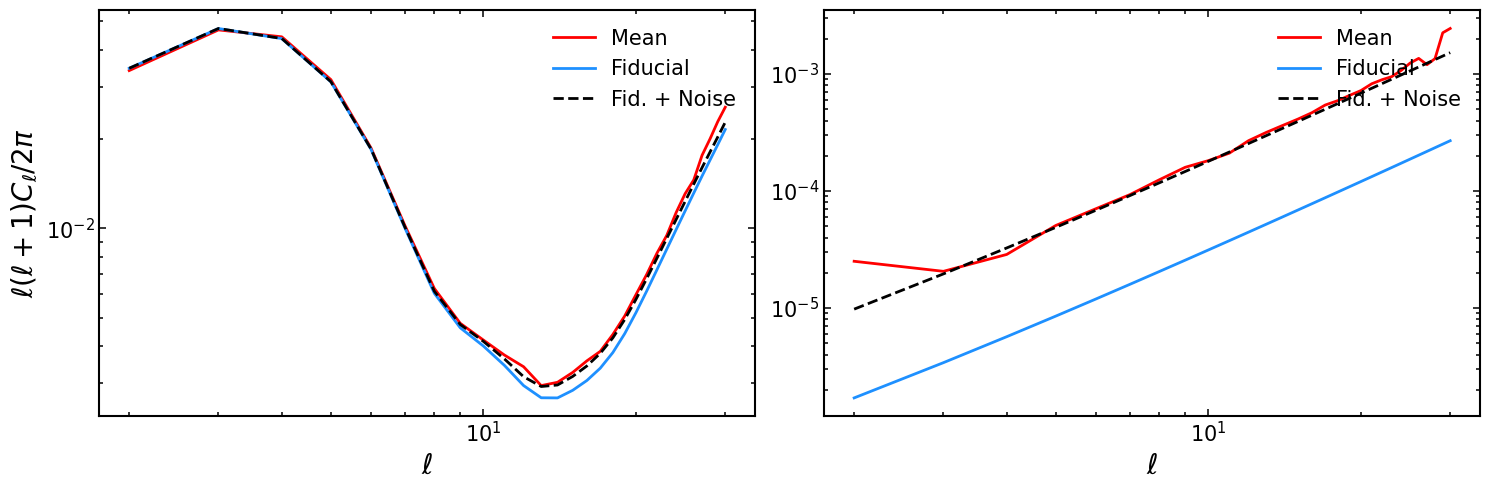

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ell, ell_factor * np.mean(cutsky_spectra[:, 0], axis=0), label="Mean")
ax[0].plot(ell, ell_factor * fiducial_spectrum[2:, 1], label="Fiducial")
ax[0].plot(ell, ell_factor * (fiducial_spectrum[2:, 1] + noise_spectrum), label="Fid. + Noise", ls = "--", color = "black")

ax[1].plot(ell, ell_factor * np.mean(cutsky_spectra[:, 1], axis=0), label="Mean")
ax[1].plot(ell, ell_factor * fiducial_spectrum[2:, 2], label="Fiducial")
ax[1].plot(ell, ell_factor * (fiducial_spectrum[2:, 2] + noise_spectrum), label="Fid. + Noise", ls = "--", color = "black")

ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")
for i in range(2):
    ax[i].loglog()
    ax[i].legend(loc = "upper right")
    ax[i].set_xlabel(r"$\ell$")

plt.show()

In [38]:
cut = None

covariance = np.cov(np.array(cutsky_spectra[: int(N_sims / 2 + 1), 1, :cut]).T)
inv_covariance = np.linalg.inv(covariance)

print(covariance.shape)

(29, 29)


In [39]:
offset = compute_offsets(
    ell[:cut],
    np.diag(covariance),
    fiducial_spectrum[2:, 2] + noise_spectrum[:cut],
    fsky=fsky_mask,
    iter=10,
)

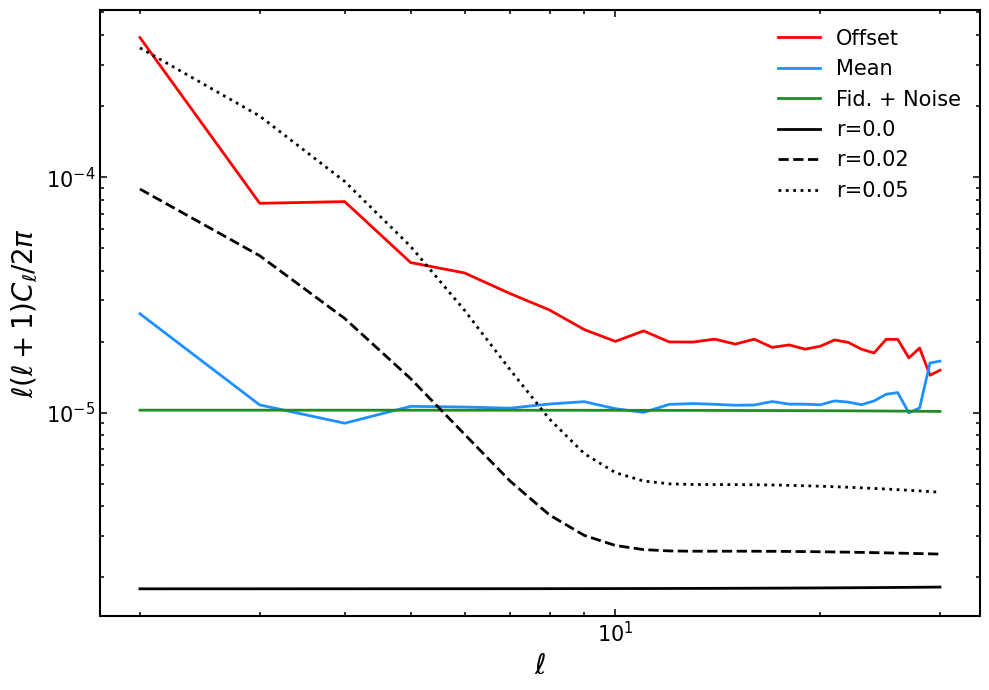

In [42]:
plt.plot(ell[:cut], offset, label="Offset")

plt.plot(ell[:cut], np.mean(cutsky_spectra[:, 1, :cut], axis=0), label="Mean")
plt.plot(ell[:cut], (fiducial_spectrum[2:, 2]*bl[2:, 2]**2 + noise_spectrum[:cut]), label="Fid. + Noise")

plt.plot(ell[:cut], templates[400][:cut], label="r=0.0", color = "black", ls="-")
plt.plot(ell[:cut], templates[600][:cut], label="r=0.02", color = "black", ls="--")
plt.plot(ell[:cut], templates[-1][:cut], label="r=0.05", color = "black", ls=":")

plt.loglog()

plt.legend(loc = "upper right")

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")

plt.show()

In [43]:
lollipop = np.zeros((len(r005s), int(N_sims / 2)))
for r_idx in tqdm(range(len(r005s)), desc="LoLLiPoP".center(30)):
    lollipop[r_idx] = get_lollipop_chi2(
                data=cutsky_spectra[int(N_sims / 2):, 1, :cut],
                template=templates[r_idx][:cut],
                fiducial=fiducial_spectrum[2:, 2],
                noise=noise_spectrum[:cut],
                offset=offset,
                inv_cov=inv_covariance,
            )

print(lollipop.shape)

           LoLLiPoP           : 100%|██████████████████████████████████████████████| 1201/1201 [00:09<00:00, 120.79it/s]

(1201, 500)


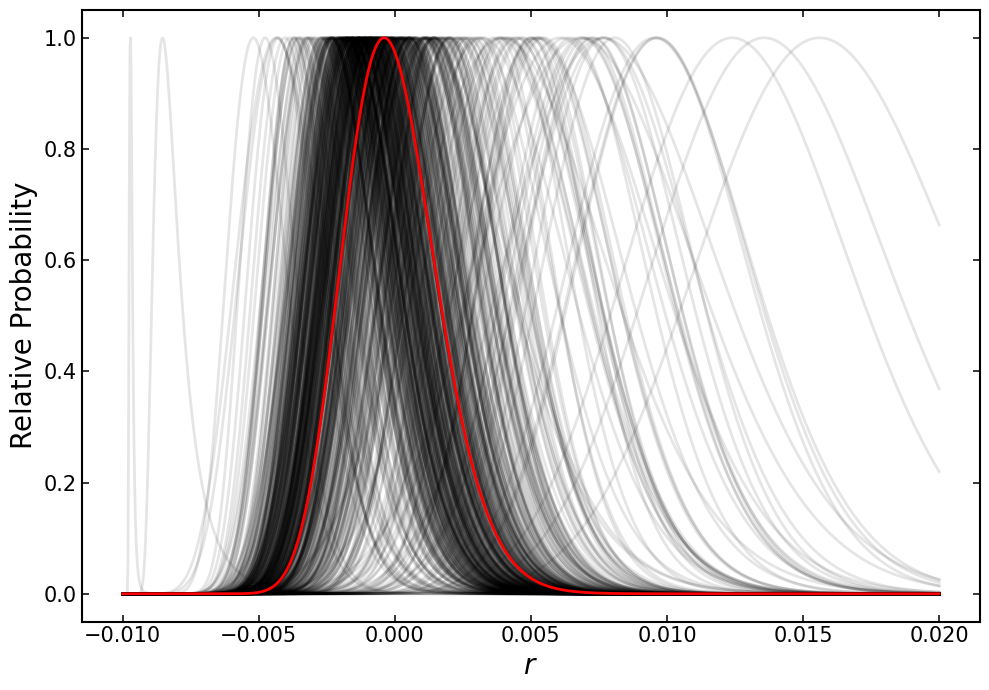

In [46]:
plt.figure()
for i in range(N_sims // 2):
    plt.plot(r005s, np.exp(-0.5*lollipop[:, i])/np.max(np.exp(-0.5*lollipop[:, i])), color= "black", alpha = 0.1)

plt.plot(r005s, np.exp(-0.5*np.mean(lollipop, axis=1))/np.max(np.exp(-0.5*np.mean(lollipop, axis=1))))

plt.xlabel(r"$r$")
plt.ylabel("Relative Probability")
plt.show()